### To Do:

- colormap gebruiken die geen overlap heeft met landmask  
- oceaan iets donkerder voor meer contrast
- standaardfout o.b.v. verschil i.p.v. referentie

In [2]:
import numpy as np
import xarray as xr
import nc_time_axis
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import tracks
%matplotlib inline

C:\Users\jsprd\Anaconda3\envs\py313\Lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [3]:
ds = tracks.load_tracks("../../tracker/jobs/Tracking_TC_RV", ext='')

REF.001: 5.000 years, 475 tracks
REF.002: 5.000 years, 484 tracks
REF.003: 5.000 years, 496 tracks
REF.004: 5.000 years, 500 tracks
REF.005: 5.000 years, 523 tracks
REF.006: 5.000 years, 462 tracks
RCP.001: 5.000 years, 445 tracks
RCP.002: 5.000 years, 437 tracks
RCP.003: 5.000 years, 459 tracks
RCP.004: 5.000 years, 464 tracks
RCP.005: 5.000 years, 455 tracks
RCP.006: 5.000 years, 473 tracks
SAI.001: 5.000 years, 425 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 412 tracks
SAI.004: 5.000 years, 430 tracks
SAI.005: 5.000 years, 406 tracks
SAI.006: 5.000 years, 421 tracks


In [3]:
# Print any remaining unexpected NaNs...
for exp in ds:
    for tid in ds[exp].id.data:
        lons = ds[exp].lon.sel(id=tid)
        if not (lons.dropna('dtime').dtime.diff('dtime') == 0.125).all().item():
            print(exp, n, tid, lons.values[:])

In [4]:
default_kwargs = {  # default line plot kwargs
    'Reference': dict(color='black', lw=2, label='Reference'),
    'RCP8.5': dict(color='orangered', lw=2, label='Control'), 
    'SAI2050': dict(color='dodgerblue', lw=2, label='SAI'),
    'RCP8.5-Reference': dict(color='red', lw=2, label='Control $-$ Ref.'), 
    'SAI2050-Reference': dict(color='green', lw=2, label='SAI $-$ Ref.'),
    'SAI2050-RCP8.5': dict(color='blue', lw=2, label='SAI $-$ Control'),
}

savefigkwargs = dict(dpi=300, bbox_inches='tight', transparent=True)
plt.rcParams['hatch.linewidth'] = 0.3
Zsig = 1.96 # max. Z-score for hatching (1.645 for 90%, 1.96 for 95% CI)

#### tracks

saving ../figures/tracks.pdf...
CPU times: total: 54.1 s
Wall time: 1min 1s


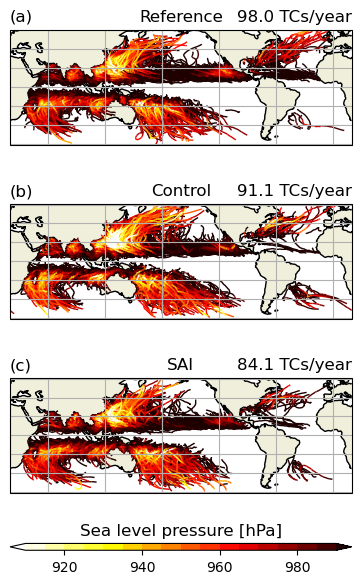

In [6]:
%%time
fname = 'tracks.pdf'
vmin, vmax, Nv = 910, 990, 17
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')
extent = (-180,180,-61,61) # (x0, x1, y0, y1)

titles = [
    ['(a)','Reference'],
    ['(b)','Control'],
    ['(c)','SAI'],
]

fig,axs = plt.subplots(3,1,figsize=(3.5,6), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
for exp, ax, title in zip(ds, axs, titles):
    segments = tracks.track_segments(ds[exp], clevels, central_longitude=200)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(central_longitude=200), capstyle='butt'), autolim=False)
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_title(title[0], loc='left')
    ax.set_title(title[1])
    ax.set_title(f'{ds[exp].id.size/ds[exp].num_days*365:.1f} TCs/year', loc='right')
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.gridlines()
#     ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50)
cb.ax.set_title('Sea level pressure [hPa]')

tracks.savefig(fig, fname, **savefigkwargs)

#### track density

In [7]:
%%time
xbins=np.arange(0, 361, 5)
ybins=np.arange(-90, 91, 5)

hists = {exp: (tracks.track_density(ds[exp], xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds}
stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1].mean('x') - hists[exp2].mean('x')
    histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    hists[exp] = hists[exp].where(histsum!=0)
    stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds:
    hists[exp] = hists[exp].mean('x', keep_attrs=True)
    hists[exp] = hists[exp].where(hists[exp]!=0)

CPU times: total: 24.6 s
Wall time: 28 s


saving ../figures/track_density.pdf...


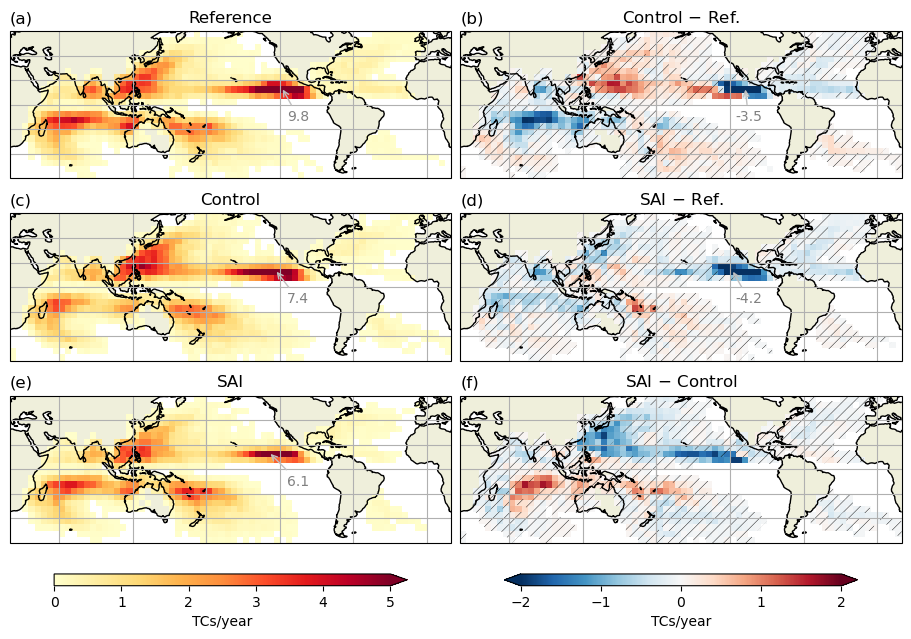

In [8]:
fname = 'track_density.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'Control',
    '(d)': 'SAI $-$ Ref.',
    '(e)': 'SAI',
    '(f)': 'SAI $-$ Control'
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-2,'vmax':2}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(3,2, figsize=(9,6.3), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[1,0] # RCP track density
cfdata = hists['RCP8.5']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')

ax = axs[2,0] # SAI track density
cfdata = hists['SAI2050']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[2,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)

saving ../figures/track_density_4panel.pdf...


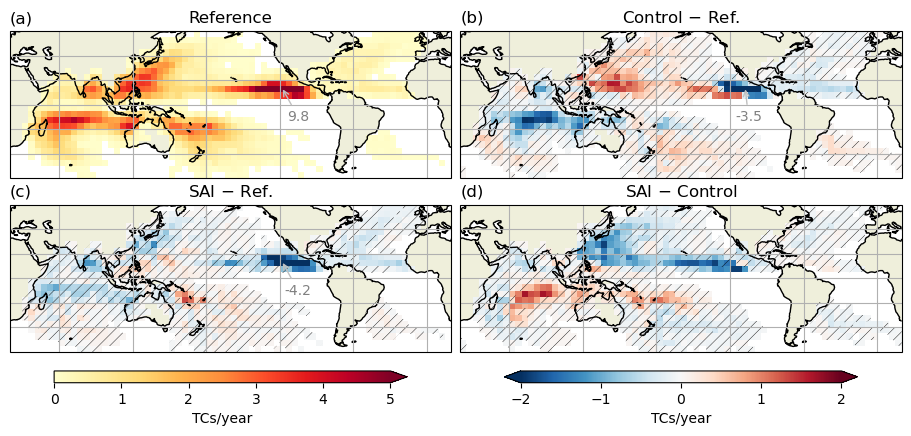

In [9]:
fname = 'track_density_4panel.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'SAI $-$ Ref.',
    '(d)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-2,'vmax':2}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(2,2, figsize=(9,4.2), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']#.hcount.mean('x')
#cfdata.data[cfdata==0] = np.nan
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
# cfdata = (hists[exps[0]].hcount.mean('x')
#           -hists[exps[1]].hcount.mean('x'))
# cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,0] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
# cfdata = (hists[exps[0]].hcount.mean('x')
#           -hists[exps[1]].hcount.mean('x'))
# cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
# cfdata = (hists[exps[0]].hcount.mean('x')
#           -hists[exps[1]].hcount.mean('x'))
# cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)

#### genesis track density

In [10]:
# xbins=np.arange(0, 361, 7.5)
# ybins=np.arange(-90, 91, 7.5)
# hists = {exp: tracks.track_density(ds[exp].isel(dtime=0), xbins=xbins, ybins=ybins) for exp in ds}
# hists = {exp: hist.stack(x=['ens','year']) for exp,hist in hists.items()}
# stderr = {exp: hists[exp].hcount.std('x', ddof=1)/np.sqrt(hists[exp].x.size) for exp in hists}

In [11]:
%%time
xbins=np.arange(0, 361, 7.5)
ybins=np.arange(-90, 91, 7.5)

hists = {exp: (tracks.track_density(
    ds[exp].isel(dtime=0), xbins=xbins, ybins=ybins
).hcount.stack(x=['ens','year'])) for exp in ds}
stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1].mean('x') - hists[exp2].mean('x')
    histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    hists[exp] = hists[exp].where(histsum!=0)
    stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds:
    hists[exp] = hists[exp].mean('x', keep_attrs=True)
    hists[exp] = hists[exp].where(hists[exp]!=0)

CPU times: total: 1.27 s
Wall time: 1.28 s


../figures/track_density_genesis.pdf already exists, cannot overwrite


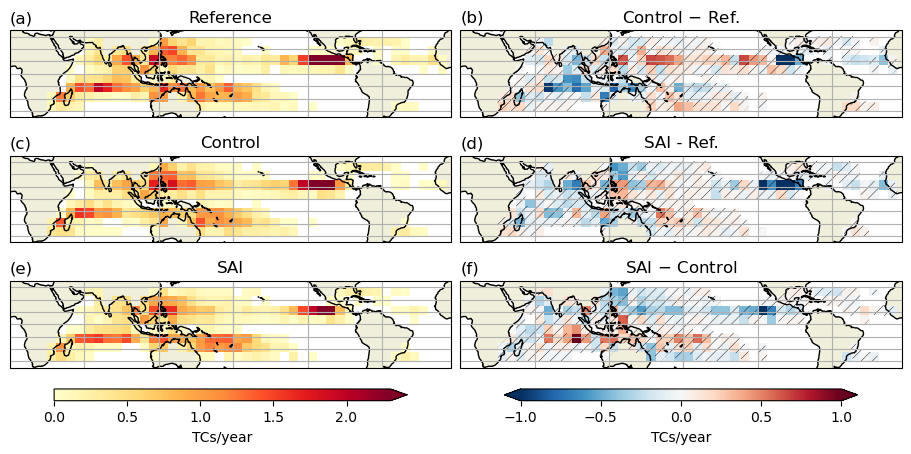

In [12]:
fname = 'track_density_genesis.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'Control',
    '(d)': 'SAI - Ref.',
    '(e)': 'SAI',
    '(f)': 'SAI $-$ Control'
}
vlims = {'ref':{'vmin':0, 'vmax':2.3}, 'diff':{'vmin':-1,'vmax':1}}

fig, axs = plt.subplots(3,2, figsize=(9,4.5), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[1,0] # RCP track density
cfdata = hists['RCP8.5']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[2,0] # SAI track density
cfdata = hists['SAI2050']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[1,1] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[2,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,356,-35,35), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)

In [13]:
%%time

def lat_density(ds, bins):
    ensyear = [(int(ens),int(year)) 
               for ens,grp in ds.year.groupby('ens') 
               for year in np.unique(grp)]

    lat_hist = np.zeros((len(ensyear),len(bins)-1))
    for ey,(ens,year) in enumerate(ensyear):
        dsi = ds.where((ds.ens==ens) & (ds.year==year), drop=True)
        lat_hist[ey],_ = np.histogram(dsi.lat, bins=bins)
    cbins = (np.array(bins)[1:] + np.array(bins[:-1]))/2
    return xr.DataArray(data=lat_hist, coords={'bins':cbins}, dims=('ensyear','bins'))

# calculate genesis latitude density (TCs/year per 2.5deg latitude box)
bin_edges = np.arange(-90,90.1,2.5)
hist_lat = xr.Dataset(
    {exp: lat_density(ds[exp].isel(dtime=0), bins=bin_edges) for exp in ds},
    coords={'bin_edges':bin_edges}
)

CPU times: total: 984 ms
Wall time: 1.02 s


In [14]:
%%time
# calculate 95% CI for genesis latitude density in Reference
qs = [0.025,0.975] # quantiles used for 95% CI

hist_lat_CI = xr.zeros_like(hist_lat.bins).expand_dims(q=qs).copy()
dsi = hist_lat['Reference']
for bn in dsi.sum('ensyear').where(dsi.sum('ensyear')!=0, drop=True).bins.data:
    hist_lat_CI.loc[dict(bins=bn)] = tracks.bootstrap(
        dsi.sel(bins=bn), np.mean, qs=qs)

CPU times: total: 2.55 s
Wall time: 2.63 s


saving ../figures/track_density_genesis_lat.pdf...


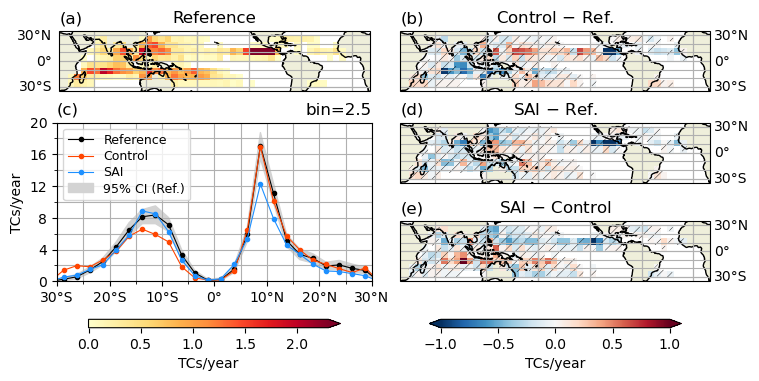

In [15]:
fname = 'track_density_genesis_lat.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {  # for maps only
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(X1)': 'Y',
    '(d)': 'SAI $-$ Ref.',
    '(X2)': 'Y',
    '(e)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':2.3}, 'diff':{'vmin':-1,'vmax':1}}

fig, axs = plt.subplots(3,2, figsize=(7.5,3.66), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
ax.gridlines(draw_labels=['left'], ylocs=[-30,0,30])

ax = axs[1,0] # RCP track density
cfdata = hists['RCP8.5']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[2,0] # SAI track density
cfdata = hists['SAI2050']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=['right'], ylocs=[-30,0,30])

ax = axs[1,1] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=['right'], ylocs=[-30,0,30])

ax = axs[2,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=['right'], ylocs=[-30,0,30])



for ax,(lab,title) in zip(axs.flat, titles.items()):
    ax.gridlines()
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,356,-35,35), crs=ccrs.PlateCarree())


gs = axs[0,0].get_gridspec()
for ax in axs[1:,0]:
    ax.remove()
#axs = axs[:-1,:]

ax_big = fig.add_subplot(gs[1:,0])
# ax_big = fig.add_axes( [
#     axs[0,0].get_position().xmin, # left
#     axs[2,1].get_position().ymin, # bottom
#     axs[0,0].get_position().width, # width
#     axs[1,1].get_position().ymax - axs[2,1].get_position().ymin, # height
# ])
# pos = axs[1,1].get_position().union((axs[1,1].get_position(), axs[2,1].get_position()))
# ax_big = fig.add_axes([0,0.2,axs[0,0].get_position().width,0.47])

ax = ax_big
ax.set_title('(c)', loc='left')
ax.set_title('bin=2.5', loc='right')
ax.plot(hist_lat.bins, hist_lat['Reference'].mean('ensyear'), marker='.', **(default_kwargs['Reference']|dict(lw=.8)))
ax.plot(hist_lat.bins, hist_lat['RCP8.5'].mean('ensyear'), marker='.', **(default_kwargs['RCP8.5']|dict(lw=.8)))
ax.plot(hist_lat.bins, hist_lat['SAI2050'].mean('ensyear'), marker='.', **(default_kwargs['SAI2050']|dict(lw=.8)))
ax.fill_between(hist_lat.bins, hist_lat_CI.isel(q=0), hist_lat_CI.isel(q=1), step=None, color='lightgrey', alpha=1, label='95% CI (Ref.)',zorder=0)
ax.set_xticks(range(-30,31,5), minor=True)
ax.set_xticks(range(-30,31,10), labels=['30°S','20°S','10°S','0°','10°N','20°N','30°N'])
ax.set_yticks(range(0,21,2), minor=True)
ax.set_yticks(range(0,21,4))
ax.set_xlim([-30,30])
ax.set_ylim([0,20])
ax.set_ylabel('TCs/year')
ax.legend(fontsize=9, loc='upper left', labelspacing=0.25)
ax.grid(which='both')

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=[axs[0,0],ax_big], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)


#### track density major vs minor TCs

In [16]:
# RV_max = {exp: tracks.track_stat(ds[exp], method='max').RV for exp in ds}
# RV_median = RV_max['Reference'].median().item()
# print(f"median RV: {RV_median*1e4:.3f}e-4 1/s (Reference)")

# xbins=np.arange(0, 361, 5)
# ybins=np.arange(-90, 91, 5)

# hists_1 = {exp: tracks.track_density(ds[exp].where(RV_max[exp]>=RV_median, drop=True), xbins=xbins, ybins=ybins) for exp in ds}
# hists_1 = {exp: hist.stack(x=['ens','year']) for exp,hist in hists_1.items()}
# stderr_1 = {exp: hists_1[exp].hcount.std('x', ddof=1)/np.sqrt(hists_1[exp].x.size) for exp in hists_1}

# hists_2 = {exp: tracks.track_density(ds[exp].where(RV_max[exp]<RV_median, drop=True), xbins=xbins, ybins=ybins) for exp in ds}
# hists_2 = {exp: hist.stack(x=['ens','year']) for exp,hist in hists_2.items()}
# stderr_2 = {exp: hists_2[exp].hcount.std('x', ddof=1)/np.sqrt(hists_2[exp].x.size) for exp in hists_2}

# num_12 = {exp: {'strong':(RV_max[exp]>=RV_median).sum().item(), 'weak':(RV_max[exp]<RV_median).sum().item()} for exp in ds}
# num_12  # number of tracks

median RV: 15.207e-4 1/s (Reference)


{'Reference': {'strong': 1470, 'weak': 1470},
 'RCP8.5': {'strong': 1418, 'weak': 1315},
 'SAI2050': {'strong': 1303, 'weak': 1221}}

In [102]:
%%time
RV_max = {exp: tracks.track_stat(ds[exp], method='max').RV for exp in ds}
RV_median = RV_max['Reference'].median().item()
print(f"median RV: {RV_median*1e4:.3f}e-4 1/s (Reference)")

xbins=np.arange(0, 361, 5)
ybins=np.arange(-90, 91, 5)

# stronger TCs
hists = {exp: (tracks.track_density(
    ds[exp].where(RV_max[exp]>=RV_median, drop=True), xbins=xbins, ybins=ybins
).hcount.stack(x=['ens','year'])) for exp in ds}
stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1].mean('x') - hists[exp2].mean('x')
    histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    hists[exp] = hists[exp].where(histsum!=0)
    stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds:
    hists[exp] = hists[exp].mean('x', keep_attrs=True)
    hists[exp] = hists[exp].where(hists[exp]!=0)
    
hists_1 = hists
stderr_1 = stderr

# weaker TCs
hists = {exp: (tracks.track_density(
    ds[exp].where(RV_max[exp]<RV_median, drop=True), xbins=xbins, ybins=ybins
).hcount.stack(x=['ens','year'])) for exp in ds}
stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1].mean('x') - hists[exp2].mean('x')
    histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    hists[exp] = hists[exp].where(histsum!=0)
    stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds:
    hists[exp] = hists[exp].mean('x', keep_attrs=True)
    hists[exp] = hists[exp].where(hists[exp]!=0)
    
hists_2 = hists
stderr_2 = stderr

# total number of tracks per group
num_12 = {exp: {'strong': (RV_max[exp]>=RV_median).sum().item(), 
                'weak': (RV_max[exp]<RV_median).sum().item()} for exp in ds}
num_12  # number of tracks

median RV: 15.207e-4 1/s (Reference)
CPU times: total: 21.2 s
Wall time: 21.8 s


{'Reference': {'strong': 1470, 'weak': 1470},
 'RCP8.5': {'strong': 1418, 'weak': 1315},
 'SAI2050': {'strong': 1303, 'weak': 1221}}

In [103]:
num_12_yr = {exp: {k:round(v/(ds[exp].num_days.item()/365),1) for k,v in num_exp.items()} for exp,num_exp in num_12.items()}
num_12_yr # number of tracks per year

{'Reference': {'strong': 49.0, 'weak': 49.0},
 'RCP8.5': {'strong': 47.3, 'weak': 43.8},
 'SAI2050': {'strong': 43.4, 'weak': 40.7}}

saving ../figures/track_density_minormajor.pdf...


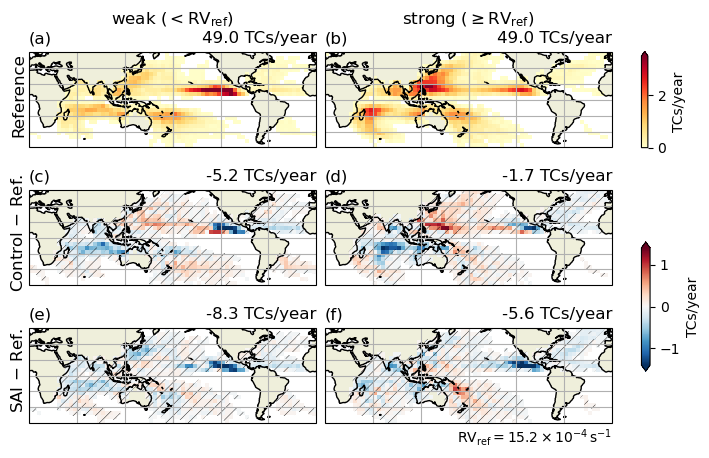

In [145]:
fname = 'track_density_minormajor.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='vertical', aspect=15)
vlims = {'ref':{'vmin':0, 'vmax':3.5}, 'diff':{'vmin':-1.4,'vmax':1.4}}

titles = {  # for maps only
    '(a)': fr"{num_12_yr['Reference']['weak']} TCs/year",
    '(b)': fr"{num_12_yr['Reference']['strong']} TCs/year",
    '(c)': fr"{num_12_yr['RCP8.5']['weak']-num_12_yr['Reference']['weak']:+.1f} TCs/year",
    '(d)': fr"{num_12_yr['RCP8.5']['strong']-num_12_yr['Reference']['strong']:+.1f} TCs/year",
    '(e)': fr"{num_12_yr['SAI2050']['weak']-num_12_yr['Reference']['weak']:+.1f} TCs/year",
    '(f)': fr"{num_12_yr['SAI2050']['strong']-num_12_yr['Reference']['strong']:+.1f} TCs/year",
}

fig, axs = plt.subplots(3,2, figsize=(7,4.5), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

ax = axs[0,0] # weak ref. track density
cfdata = hists_2['Reference']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[0,1] # strong ref. track density
cfdata = hists_1['RCP8.5']
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[1,0] # weak RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists_2[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr_2[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[1,1] # strong RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists_1[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr_1[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[2,0] # weak SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists_2[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr_2[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[2,1] # strong SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists_1[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr_1[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,ylab in zip(axs[:,0], ['Reference','Control $-$ Ref.','SAI $-$ Ref.']):
    ax.text(-0.01, 0.55, ylab, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize='large')
axs[0,0].set_title(r'weak ($< \mathrm{RV}_{\mathrm{ref}}$)'+'\n')
axs[0,1].set_title(r'strong ($\geq \mathrm{RV}_{\mathrm{ref}}$)'+'\n')
    
for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title, loc='right')
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())
    
# axs[-1,1].set_xlabel(rf"RV$_{{\mathrm{{ref}}}}={RV_median*1e4:.1f}\times 10^{{-4}} \mathrm{{s}}^{{-1}}$")
axs[-1,1].text(1, -0.2, rf"RV$_{{\mathrm{{ref}}}}={RV_median*1e4:.1f}\times 10^{{-4}}\,\mathrm{{s}}^{{-1}}$", ha='right', transform=ax.transAxes)

cb = fig.colorbar(cf_ref, ax=axs[0,:], extend='max', shrink=.8, **cbkwargs)
cb.ax.set_ylabel('TCs/year')
cb = fig.colorbar(cf, ax=axs[1:,:], extend='both', shrink=0.5, **cbkwargs)
cb.ax.set_ylabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)

#### track density 10% strongest by U10

In [20]:
# xbins=np.arange(0, 361, 5)
# ybins=np.arange(-90, 91, 5)
# U10_90pct = ds['Reference'].U10.max('dtime').quantile(0.9).item() # 90th percentile of lifetime maximum U10
# hists = {exp: tracks.track_density(ds[exp].where(ds[exp].U10>=U10_90pct, drop=True), xbins=xbins, ybins=ybins) for exp in ds}
# hists = {exp: hist.stack(x=['ens','year']) for exp,hist in hists.items()}
# stderr = {exp: hists[exp].hcount.std('x', ddof=1)/np.sqrt(hists[exp].x.size) for exp in hists}

In [5]:
%%time
xbins=np.arange(0, 361, 7.5)
ybins=np.arange(-90, 91, 7.5)
U10_90pct = ds['Reference'].U10.max('dtime').quantile(0.9).item() # 90th percentile of lifetime maximum U10

hists = {exp: (tracks.track_density(
    ds[exp].where(ds[exp].U10>=U10_90pct, drop=True), xbins=xbins, ybins=ybins
).hcount.stack(x=['ens','year'])) for exp in ds}
stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1].mean('x') - hists[exp2].mean('x')
    histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    hists[exp] = hists[exp].where(histsum!=0)
    stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds:
    hists[exp] = hists[exp].mean('x', keep_attrs=True)
    hists[exp] = hists[exp].where(hists[exp]!=0)

CPU times: total: 5.22 s
Wall time: 5.86 s


saving ../figures/track_density_U90pct.pdf...


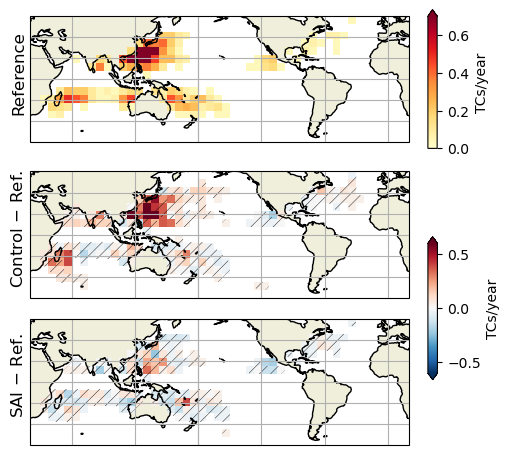

In [7]:
fname = 'track_density_U90pct.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='vertical', aspect=15)
vlims = {'ref':{'vmin':0, 'vmax':0.7}, 'diff':{'vmin':-0.6,'vmax':0.6}}

fig, axs = plt.subplots(3,1, figsize=(5,4.5), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0] # weak ref. track density
cfdata = hists['Reference']#.hcount.mean('x')
# cfdata.data[cfdata==0] = np.nan
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)

ax = axs[1] # weak RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
# cfdata = (hists[exps[0]].hcount.mean('x')
#           -hists[exps[1]].hcount.mean('x'))
# cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
# si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

ax = axs[2] # weak SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
# cfdata = (hists[exps[0]].hcount.mean('x')
#           -hists[exps[1]].hcount.mean('x'))
# cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
# si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,ylab in zip(axs[:], ['Reference','Control $-$ Ref.','SAI $-$ Ref.']):
    ax.text(-0.01, 0.55, ylab, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize='large')

#axs[0].set_title(r'$V_{\mathrm{max}}^{10}$'+f' > {U10_90pct:.1f} m/s')
    
for ax in axs.flatten():
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())
    ax.gridlines()
    ax.coastlines()
#     ax.stock_img()
    ax.add_feature(cfeature.LAND)

cb = fig.colorbar(cf_ref, ax=axs[0], extend='max', shrink=1, **cbkwargs)
cb.ax.set_ylabel('TCs/year')
cb = fig.colorbar(cf, ax=axs[1:], extend='both', shrink=0.5, **cbkwargs)
cb.ax.set_ylabel('TCs/year')

tracks.savefig(fig, fname, **savefigkwargs)

#### TC hours per day

In [26]:
# create annual mean and variance of NH/SH daily TC hours
ydata_NH = {}
for exp in ds:
    lats = ds[exp].isel(dtime=0).lat
    ds_NH = ds[exp].where(lats>0).dropna('id', how='all')
    ydata = tracks.assign_dayofyear(tracks.TChoursperday(ds_NH))
    ydata = ydata.roll(dayofyear=-90, roll_coords=True)
    ydata['doy'] = ('dayofyear', np.array(range(365))+ydata.dayofyear[0].item()) # monotonically increasing doy needed for plotting
    ydata_NH[exp] = ydata

ydata_SH = {}
for exp in ds:
    lats = ds[exp].isel(dtime=0).lat
    ds_SH = ds[exp].where(lats<=0).dropna('id', how='all')
    ydata = tracks.assign_dayofyear(tracks.TChoursperday(ds_SH))
    ydata = ydata.roll(dayofyear=154, roll_coords=True)
    ydata['doy'] = ('dayofyear', np.array(range(365))+ydata.dayofyear[0].item()) # monotonically increasing doy needed for plotting
    ydata_SH[exp] = ydata

../figures/TC_count_NH_SH.pdf already exists, cannot overwrite


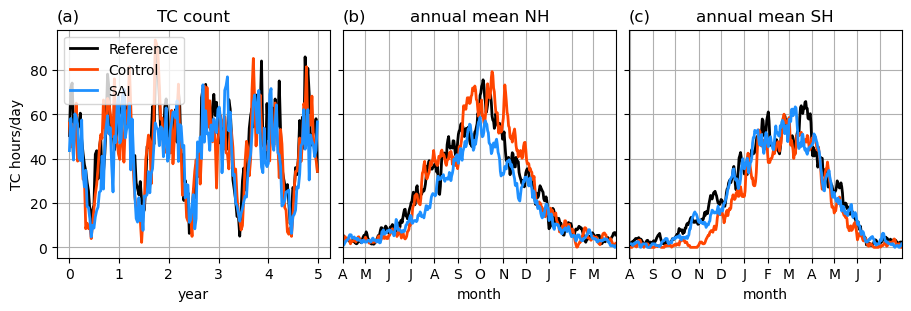

In [27]:
figname = 'TC_count_NH_SH.pdf'

fig, axs = plt.subplots(1,3, figsize=(9,3), sharey=True, layout='constrained')

ax = axs[0]
for exp in ds:
    ydata = tracks.TChoursperday(ds[exp])
    ydata = ydata.resample(time='10D').mean()
    ydata['time'] = ydata.time - cftime.DatetimeNoLeap(ydata.time[0].dt.year,1,1)
    ax.plot(ydata.time.dt.total_seconds()/86400/365, ydata.mean('ens'), **default_kwargs[exp])
t = ax.set_title("TC count")
ax.set_title('(a)', loc='left')
ax.set_xlabel("year")
ax.legend()
ax.grid()
ax.set_ylabel("TC hours/day")

xticks = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) + 1
xticklabs = ['J','F','M','A','M','J','J','A','S','O','N','D']

ax = axs[1]
for exp in ds:
    ydata = ydata_NH[exp]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax.plot(ydata.doy, ydata.mean(('ens','year')), **default_kwargs[exp])
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
t = ax.set_title("annual mean NH")
ax.set_title("(b)", loc='left')
ax.set_xlabel("month")
ax.grid()

ax = axs[2]
for exp in ds:
    ydata = ydata_SH[exp]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax.plot(ydata.doy, ydata.mean(('ens','year')), **default_kwargs[exp])
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
t = ax.set_title("annual mean SH")
ax.set_title("(c)", loc="left")
ax.set_xlabel("month")
ax.grid()

tracks.savefig(fig, figname, **savefigkwargs)

Daily sum of TC hours, i.e. the track duration on any given day summed over all active tracks. a) shows the ensemble mean daily sum of TC hours, smoothed by a 10-day running mean, b) and c) show the ensemble mean interannual mean daily sum of TC hours for the Northern and Southern Hemisphere, respectively.

In [63]:
n = 20 # window size (centered) along dayofyear

ydata_NHMA = {exp: tracks.rolling_rolling(ydata, n, 'dayofyear', 'ddoy').stack(x=['ens','year']) 
              for exp,ydata in ydata_NH.items()}
ydata_SHMA = {exp: tracks.rolling_rolling(ydata, n, 'dayofyear', 'ddoy').stack(x=['ens','year']) 
              for exp,ydata in ydata_SH.items()}

# calculate 95% confidence interval for Reference
exp = 'Reference'
ydata_NHMACI = xr.zeros_like(ydata_NHMA[exp].mean(('x','ddoy'))).expand_dims(qs=[0.025,0.975]).copy()
for doy in ydata_NHMACI.dayofyear.data:
    q1, q2 = tracks.bootstrap(ydata_NHMA[exp].sel(dayofyear=doy).mean('ddoy'), np.mean)
    ydata_NHMACI.loc[dict(dayofyear=doy)] = [q1, q2]
    
ydata_SHMACI = xr.zeros_like(ydata_SHMA[exp].mean(('x','ddoy'))).expand_dims(qs=[0.025,0.975]).copy()
for doy in ydata_SHMACI.dayofyear.data:
    q1, q2 = tracks.bootstrap(ydata_SHMA[exp].sel(dayofyear=doy).mean('ddoy'), np.mean)
    ydata_SHMACI.loc[dict(dayofyear=doy)] = [q1, q2]

# calculate rolling window mean and standard error 
ydata_NHMA = {exp: (ydata.mean(('x','ddoy'), keep_attrs=True), ydata.std('x', ddof=1, keep_attrs=True).mean('ddoy', keep_attrs=True)/np.sqrt(ydata.x.size))
             for exp,ydata in ydata_NHMA.items()}
ydata_SHMA = {exp: (ydata.mean(('x','ddoy'), keep_attrs=True), ydata.std('x', ddof=1, keep_attrs=True).mean('ddoy', keep_attrs=True)/np.sqrt(ydata.x.size))
             for exp,ydata in ydata_SHMA.items()}

saving ../figures/TC_count_NH_SH_MA20.pdf...


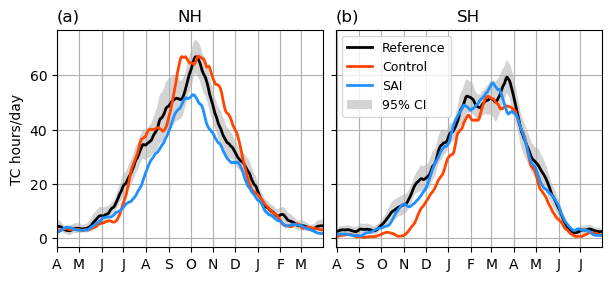

In [101]:
fname = 'TC_count_NH_SH_MA20.pdf'
fig, axs = plt.subplots(1,2, figsize=(6,2.7),sharey='row', layout='constrained')

xticks = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) + 1
xticklabs = ['J','F','M','A','M','J','J','A','S','O','N','D']

ax = axs[0]
ydata = ydata_NHMA['Reference'][0]
ydataCI = ydata_NHMACI
ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
for exp,ydata in ydata_NHMA.items():
    y_mean, y_se = ydata
    ax.plot(y_mean.doy, y_mean, **default_kwargs[exp])
ax.fill_between(ydata_NHMACI.doy, ydata_NHMACI.isel(qs=0), 
                ydata_NHMACI.isel(qs=1), fc='lightgrey', label='95% CI')  

ax = axs[1]
ydata = ydata_SHMA['Reference'][0]
ydataCI = ydata_SHMACI
ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
for exp,ydata in ydata_SHMA.items():
    y_mean, y_se = ydata
    ax.plot(y_mean.doy, y_mean, **default_kwargs[exp])
ax.fill_between(ydata_SHMACI.doy, ydata_SHMACI.isel(qs=0), 
                ydata_SHMACI.isel(qs=1), fc='lightgrey', label='95% CI')    

axs[0].set_ylabel('TC hours/day')
axs[0].set_title('NH')
axs[0].set_title('(a)', loc='left')
axs[1].set_title('SH')
axs[1].set_title('(b)', loc='left')
axs[1].legend(loc='upper left', fontsize=9)

[axi.grid() for axi in axs.flat]

tracks.savefig(fig, fname, **savefigkwargs)

In [100]:
exp = 'Reference'
TCdays_NHref = ydata_NH[exp].mean(('year','ens')).sum('dayofyear')/24
TCdays_SHref = ydata_SH[exp].mean(('year','ens')).sum('dayofyear')/24

print(f"NH: TC days/year (% change from Ref.)")
for exp in ds:
    TCdays_NH = ydata_NH[exp].mean(('year','ens')).sum('dayofyear')/24
    print(f"{exp:9}: {TCdays_NH:.1f} ({(TCdays_NH-TCdays_NHref)/TCdays_NHref*100:+.1f}%)")

print(f"\nSH: TC days/year (% change from Ref.)")
for exp in ds:
    TCdays_SH = ydata_SH[exp].mean(('year','ens')).sum('dayofyear')/24
    print(f"{exp:9}: {TCdays_SH:.1f} ({(TCdays_SH-TCdays_SHref)/TCdays_SHref*100:+.1f}%)")

NH: TC days/year (% change from Ref.)
Reference: 366.3 (+0.0%)
RCP8.5   : 383.8 (+4.8%)
SAI2050  : 291.4 (-20.5%)

SH: TC days/year (% change from Ref.)
Reference: 349.6 (+0.0%)
RCP8.5   : 273.8 (-21.7%)
SAI2050  : 328.1 (-6.1%)


../figures/TC_count_NH_SH_diff.pdf already exists, cannot overwrite


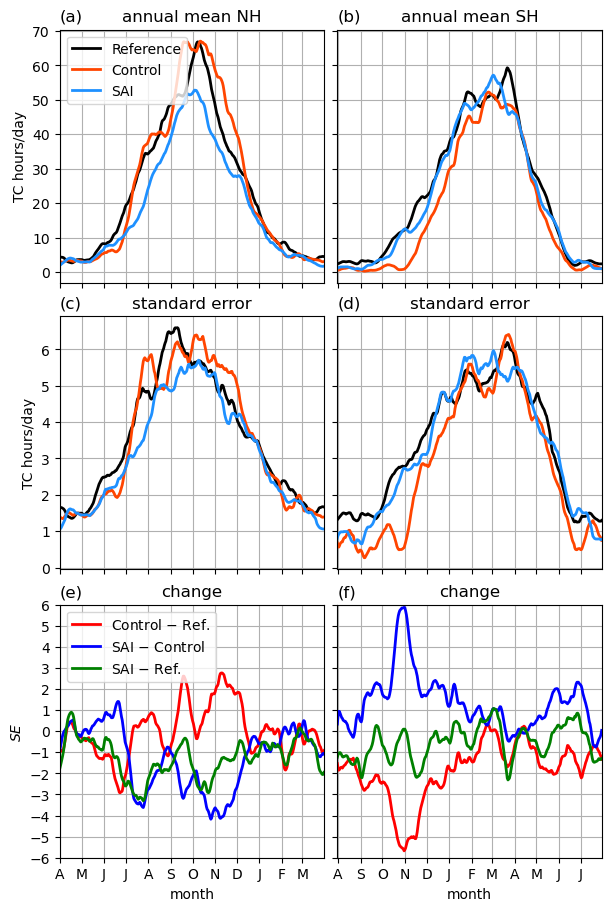

In [22]:
fname = 'TC_count_NH_SH_diff.pdf'
fig, axs = plt.subplots(3,2, figsize=(6,9), sharex='col',sharey='row', layout='constrained')

xticks = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) + 1
xticklabs = ['J','F','M','A','M','J','J','A','S','O','N','D']

for ax, plot_data in zip([axs[:,0],axs[:,1]],[ydata_NHMA,ydata_SHMA]):
    ydata = plot_data['Reference'][0]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax[0].set_xticks(ydata.doy[ids], xticklabs)
    ax[0].set_xlim((ydata.doy.min(),ydata.doy.max()))
    for exp,ydata in plot_data.items():
        y_mean, y_se = ydata
        ax[0].plot(y_mean.doy, y_mean, **default_kwargs[exp])
        ax[1].plot(y_se.doy, y_se, **default_kwargs[exp])
    
    ax[2].set_yticks(range(-6,7))
    ax[2].set_ylim([-6,6])
    for exps in ['RCP8.5-Reference','SAI2050-RCP8.5','SAI2050-Reference']:
        exp2, exp1 = exps.split('-')
        y_mean = plot_data[exp2][0] - plot_data[exp1][0]
        y_se = np.sqrt(plot_data[exp2][1]**2 + plot_data[exp1][1]**2)/np.sqrt(2)
        ax[2].plot(y_mean.doy, y_mean/y_se, **default_kwargs[exps])

axs[-1,0].set_xlabel("month")
axs[-1,1].set_xlabel("month")
axs[0,0].set_ylabel('TC hours/day')
axs[1,0].set_ylabel('TC hours/day')
axs[2,0].set_ylabel('$SE$')
axs[0,0].set_title('annual mean NH')
axs[0,0].set_title('(a)', loc='left')
axs[0,1].set_title('annual mean SH')
axs[0,1].set_title('(b)', loc='left')
axs[1,0].set_title('standard error')
axs[1,0].set_title('(c)', loc='left')
axs[1,1].set_title('standard error')
axs[1,1].set_title('(d)', loc='left')
axs[2,0].set_title('change')
axs[2,0].set_title('(e)', loc='left')
axs[2,1].set_title('change')
axs[2,1].set_title('(f)', loc='left')
axs[0,0].legend(loc='upper left')
axs[2,0].legend(loc='upper left')

[axi.grid() for axi in axs.flat]

tracks.savefig(fig, fname, **savefigkwargs)


Daily sum of TC hours smoothed by a 20-day running mean for the NH (left) and SH (right). Ensemble mean annual mean values are shown in the top row, standard error over the ensemble members and years are shown in the center row and differences between experiments expressed in standard errors over each respective combination of experiments are shown in the bottom row.

../figures/hist_maxRV_SE_PSL_U10_PRECT_lat.pdf already exists, cannot overwrite


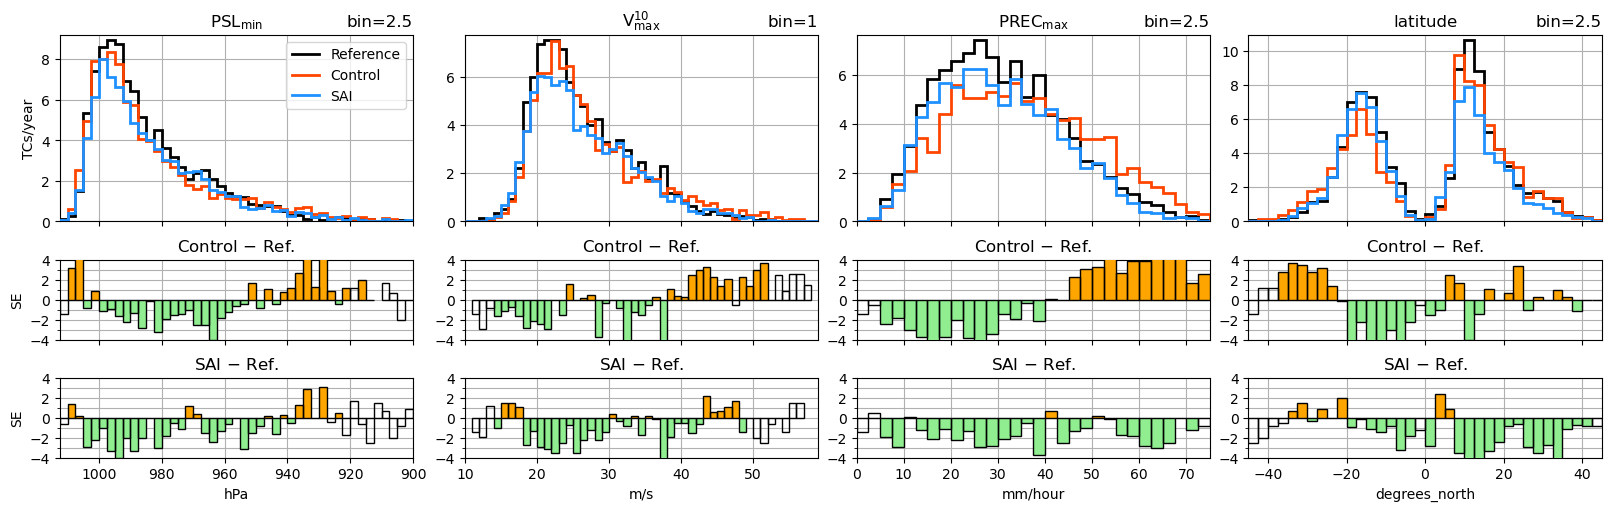

In [23]:
hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(900,1015,2.5), 'title': r'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': r'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,60,1), 'title': r'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': r'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': r'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': r'|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,2.5), 'title': r'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': r'$\Delta$T$^{850}$', 'rev':False},
}

yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['PSL','U10','PRECT','lat'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

tracks.savefig(fig, fname, **savefigkwargs)

../figures/hist_maxRV_SE_lon_lat_PSLmon_RV.pdf already exists, cannot overwrite


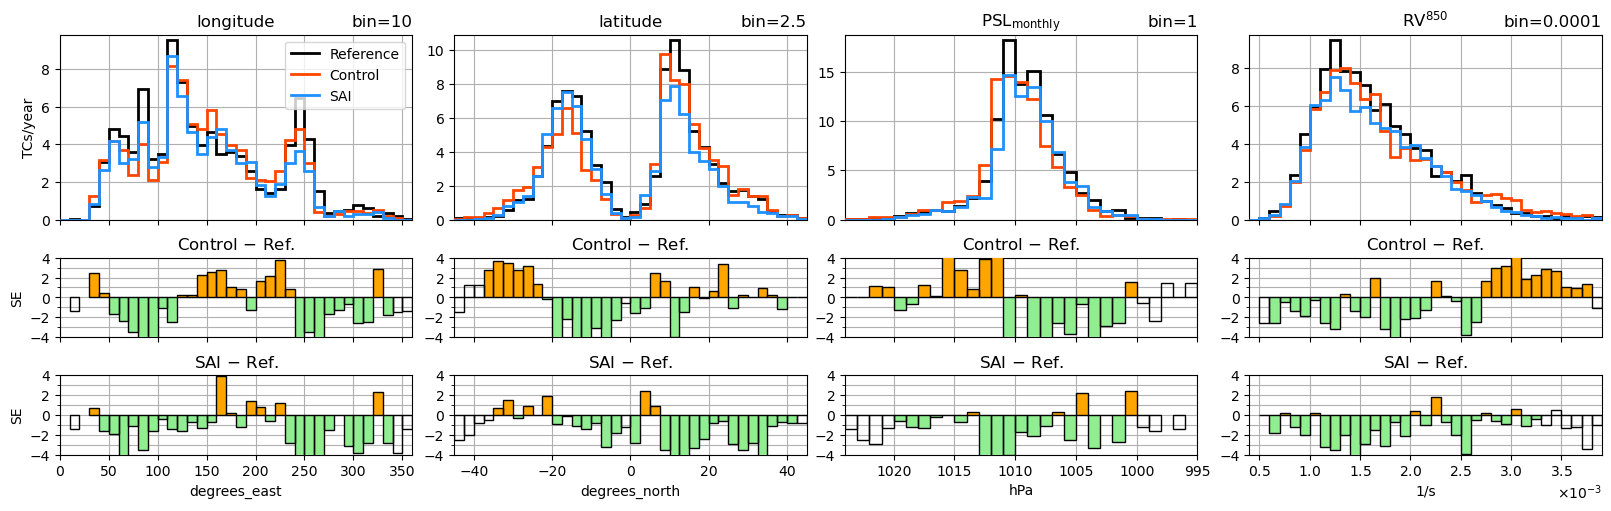

In [24]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['lon','lat','PSLmon','RV'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,3].ticklabel_format(scilimits=(-3,3), useMathText=True) # sci notation for RV
tracks.savefig(fig, fname, **savefigkwargs)

../figures/hist_maxRV_SE_SST_SSTmon_Vshear_TEMP.pdf already exists, cannot overwrite


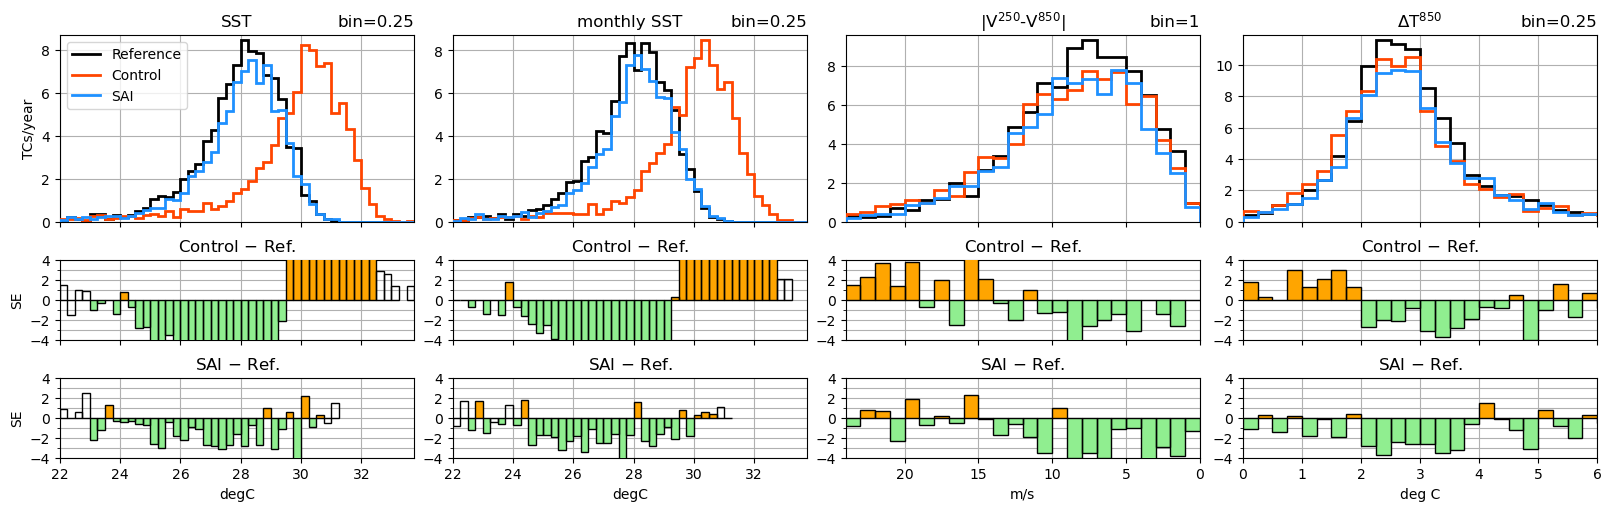

In [25]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['SST','SSTmon','Vshear','TEMP'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,3].set_xlim([0,6])
tracks.savefig(fig, fname, **savefigkwargs)

../figures/hist_develop_SE_SST_Vshear_TEMP.pdf already exists, cannot overwrite


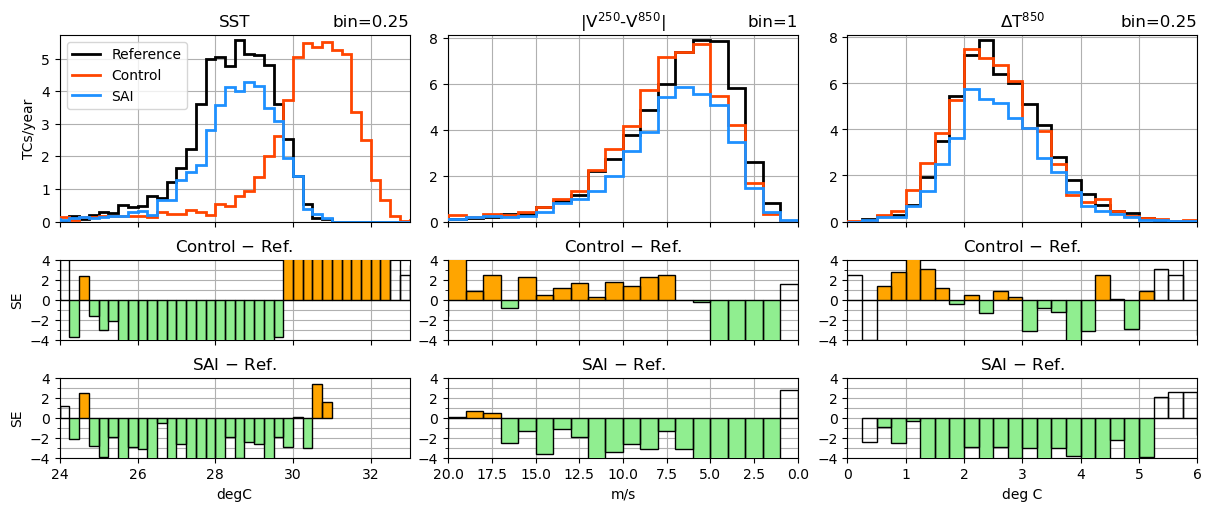

In [26]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'develop'         # reduction method (passed to track_stat)
plot_vars = ['SST','Vshear','TEMP'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,plot_vars.index('SST')].set_xlim([24,33])
axs[0,plot_vars.index('Vshear')].set_xlim([20,0])
axs[0,plot_vars.index('TEMP')].set_xlim([0,6]) # for core temp anomaly
tracks.savefig(fig, fname, **savefigkwargs)

In [27]:
histREF = tracks.track_density(ds['Reference'], xbins=np.arange(0,360.1,1), ybins=np.arange(-90,90.1,1)).hcount.stack(x=('ens','year'))
histCNT = tracks.track_density(ds['RCP8.5'], xbins=np.arange(0,360.1,1), ybins=np.arange(-90,90.1,1)).hcount.stack(x=('ens','year'))
histSAI = tracks.track_density(ds['SAI2050'], xbins=np.arange(0,360.1,1), ybins=np.arange(-90,90.1,1)).hcount.stack(x=('ens','year'))
hist = xr.concat((histREF,histCNT,histSAI), dim='x').sum('x')
hist = hist.where(hist!=0)

../figures/domains.pdf already exists, cannot overwrite


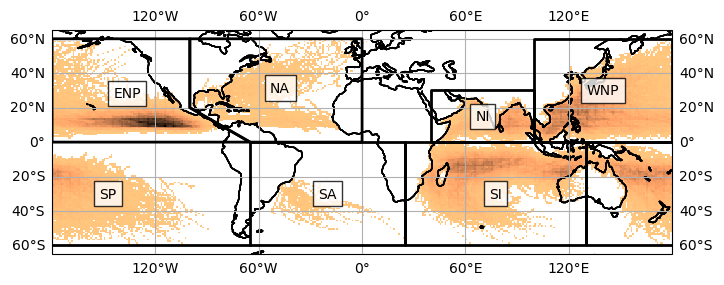

In [28]:
fname = 'domains.pdf'
fig = plt.figure(figsize=(8,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-180,180,-65,65))
for dom in tracks.domains:
    ax.add_geometries(tracks.domains[dom], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, alpha=1, zorder=5)
    ax.text(tracks.domains[dom].centroid.x, tracks.domains[dom].centroid.y, dom, va='center', ha='center', transform=ccrs.PlateCarree(), 
            zorder=5, bbox=dict(facecolor='white', alpha=0.8))
    ax.coastlines()
    #ax.stock_img()
pcm = ax.pcolormesh(hist.xbins, hist.ybins, hist, transform=ccrs.PlateCarree(), vmin=None, vmax=None, cmap='copper_r', zorder=1)
ax.plot([-180,-65],[-60,-60], transform=ccrs.PlateCarree(), c='k', lw=2, zorder=5)
ax.gridlines(alpha=1, linestyle='-', draw_labels=True, zorder=4)

tracks.savefig(fig, fname, **savefigkwargs)

In [29]:
# estimate for vmin, vmax (track figure)
dom = 'ENP'
tracks.select_region(ds['RCP8.5'], dom).PSL.quantile([0.01,0.5]).data

array([ 973.95558655, 1003.02182007])

../figures/regional/tracks_ENP.pdf already exists, cannot overwrite


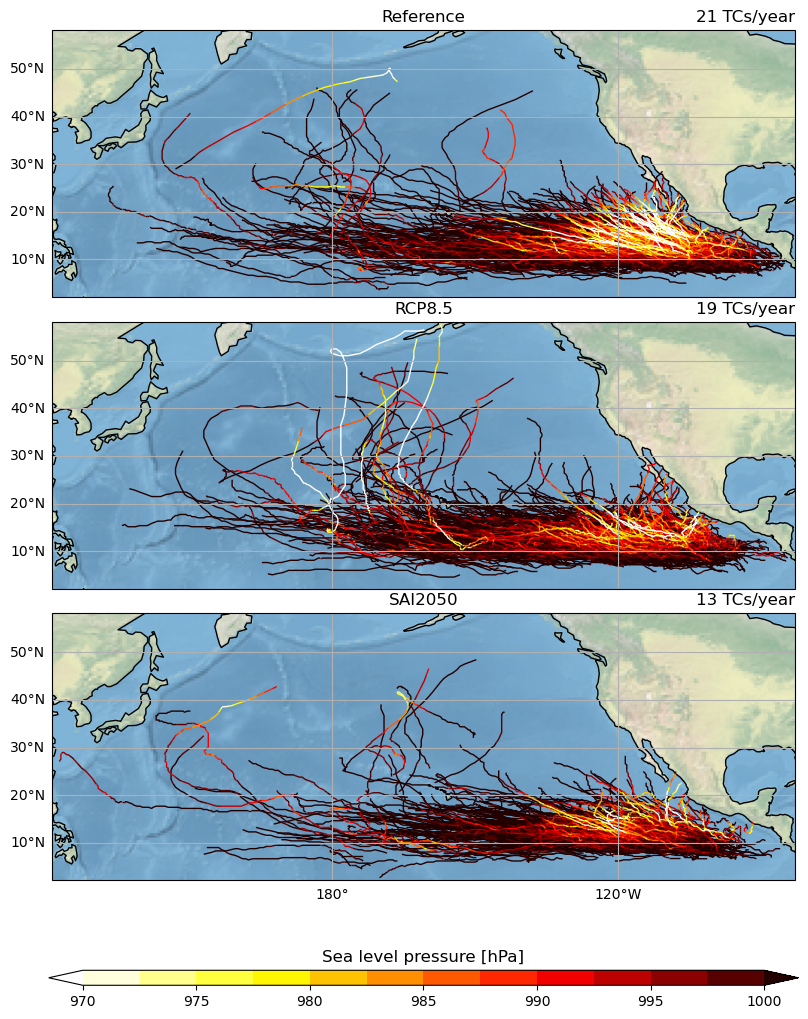

In [30]:
dom = 'ENP'

################### track figure #######################

fname = f'tracks_{dom}.pdf'
fdir = '../figures/regional/'
vmin, vmax = 970, 1000
Nv = round((vmax-vmin)/2.5)+1
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')
central_lon = round(tracks.domains[dom].centroid.x)

fig,axs = plt.subplots(3,1,figsize=(8,10), constrained_layout=True, sharex=True, sharey=True,
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=central_lon),
                                   'xmargin':0.01, 'ymargin':0.01})
for exp, ax in zip(ds, axs):
    dsi = tracks.select_region(ds[exp], dom)
    segments = tracks.track_segments(dsi, clevels, central_longitude=central_lon)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(central_longitude=central_lon), capstyle='butt'))
    ax.set_title(exp)
    ax.set_title(f'{dsi.id.size/ds[exp].num_days*365:.0f} TCs/year', loc='right')
    ax.coastlines()
    ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

for ax in axs: # must be after plotting to prevent setting a global view
    ax.stock_img()

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50, shrink=1)
cb.ax.set_title('Sea level pressure [hPa]')

tracks.savefig(fig, fname, figpath=fdir, **savefigkwargs)

../figures/regional/hist_maxRV_WNP_SE_PSL_U10_PRECT_lat.pdf already exists, cannot overwrite


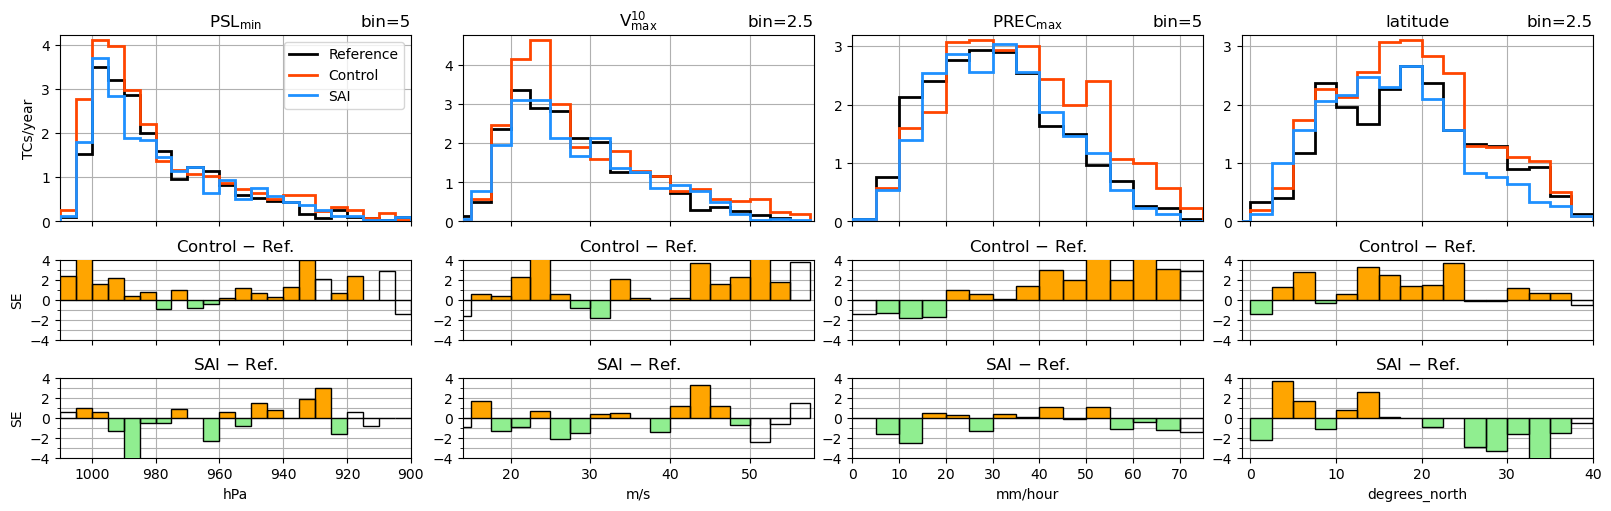

In [31]:
############## PSL, RMW, V, PREC figure @ max RV ######################

dom = 'WNP'
method = 'maxRV'         # reduction method (passed to track_stat)
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
plot_vars = ['PSL','U10','PRECT','lat'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{dom}_{ytag}_{'_'.join(plot_vars)}.pdf"
fdir = '../figures/regional/'

hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(900,1015,5), 'title': r'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': r'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,60,2.5), 'title': r'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': r'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': r'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': r'|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,5), 'title': r'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': r'$\Delta$T$^{850}$', 'rev':False},
}

# hist_kwargs['PSL']['bins'] = np.arange(900,1015,5)
# hist_kwargs['U10']['bins'] = np.arange(10,60,2.5)
# hist_kwargs['PRECT']['bins'] = np.arange(0,76,5)
# hist_kwargs['lat']['bins'] = np.arange(-45,45.1,2.5)

fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(16,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

dsi = {exp: tracks.select_region(ds[exp], dom) for exp in ds}
dsi = {exp: tracks.track_stat(dsi[exp], method=method) for exp in dsi}
#xlims = dsi['Reference'].quantile([0.0,1])

for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(dsi[exp][var], hist_kwargs[var]['bins']) for exp in dsi}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(dsi['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    # axs[2,col].set_xlim(xlims[var])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

# axs[0,0].set_xlim([1015,945])
axs[0,1].set_xlim([14,58])
# axs[0,2].set_xlim([0,50])
axs[0,3].set_xlim([-1,40])

tracks.savefig(fig, fname, figpath=fdir, **savefigkwargs)

../figures/regional/hist_develop_WNP_SE_Vshear_SST.pdf already exists, cannot overwrite


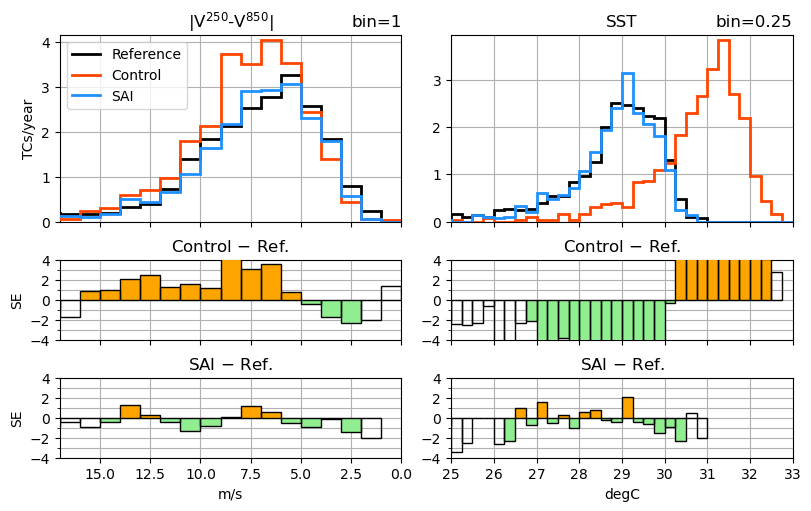

In [32]:
############### SHEAR, SST figure #################

dom = 'WNP'
method = 'develop'         # reduction method (passed to track_stat)
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
plot_vars = ['Vshear','SST'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{dom}_{ytag}_{'_'.join(plot_vars)}.pdf"
fdir = '../figures/regional/'

#fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
fig,axs = plt.subplots(3,2, height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0.01, ymargin=0.03))
if len(plot_vars) == 1:
    axs = axs[:,np.newaxis]

dsi = {exp: tracks.select_region(ds[exp], dom) for exp in ds}
dsi = {exp: tracks.track_stat(dsi[exp], method=method) for exp in dsi}

for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(dsi[exp][var], hist_kwargs[var]['bins']) for exp in dsi}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(dsi['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,0].set_xlim([17,0])
axs[0,1].set_xlim([25,33])

tracks.savefig(fig, fname, figpath=fdir, **savefigkwargs)

Text(0.5, 1.0, 'Bootstrapped')

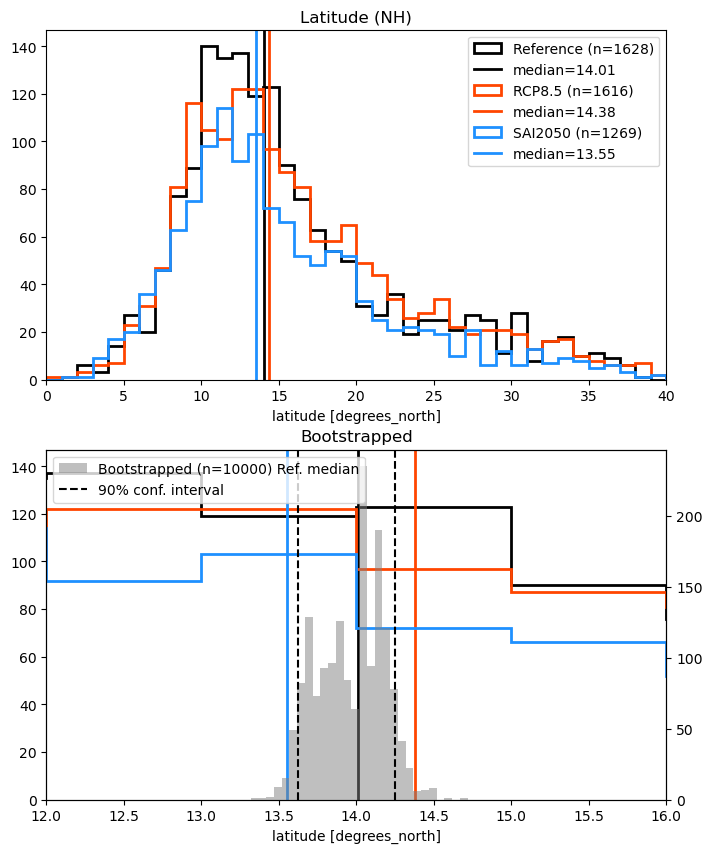

In [33]:
ds_stat = {method: {exp: tracks.track_stat(ds[exp], method) for exp in ds} 
           for method in ['mean','maxRV','develop','maxdeep']}
bins = np.arange(0,91)
fig, axs = plt.subplots(2,1, figsize=(8,10))
for exp in ds:
    lats = ds_stat['mean'][exp].lat
    lats_NH = lats.where(lats>=0, drop=True)
    lats_NH.plot.hist(ax=axs[0], bins=bins, histtype='step', **(default_kwargs[exp] | {'label':exp+f' (n={lats_NH.id.size})'}))
    lats_NH.plot.hist(ax=axs[1], bins=bins, histtype='step', **(default_kwargs[exp] | {'label':exp+f' (n={lats_NH.id.size})'}))
    axs[0].axvline(lats_NH.median(), **(default_kwargs[exp] | {'label':f"median={lats_NH.median():.2f}"}))
    axs[1].axvline(lats_NH.median(), **(default_kwargs[exp] | {'label':f"median={lats_NH.median():.2f}"}))
axs[0].legend()
axs[0].set_xlim([0,40])
axs[0].set_title('Latitude (NH)')

lats = ds_stat['mean']['Reference'].lat
lats_NH = lats.where(lats>=0, drop=True)
all_quants = tracks.bootstrap(lats_NH, np.quantile, [0.5], qs=np.linspace(0,1,len(lats_NH)))
confidence_lims2 = tracks.bootstrap(lats_NH, np.quantile, [0.5])

ax2 = axs[1].twinx()
hist,edges = np.histogram(all_quants, bins=np.arange(all_quants.min(),all_quants.max()+0.04, 0.05))
ax2.stairs(hist, fill=True, alpha=0.5, color='gray', edges=edges, label=f'Bootstrapped (n=10000) Ref. median')
ax2.axvline(confidence_lims2[0], c='k', ls='--', label='90% conf. interval')
ax2.axvline(confidence_lims2[1], c='k', ls='--')
ax2.legend()
axs[1].set_xlim([12,16])
axs[1].set_title('Bootstrapped') 